In [15]:
import os 
import glob
import numpy as np
import shutil
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from itertools import groupby
from operator import itemgetter
import pandas as pd
pd.set_option("display.max_rows",2000)
pd.set_option("display.max_columns",2000)


In [31]:
# unzip BO_data.zip before proceeding further
# code: unzip BO_data.zip -d BO_data

In [ ]:
# Load parameter combinations
param_df = pd.read_csv("BO_data/Params.csv")
param_df.head()

,lambda,jcc,k
0,500,1,0.001
1,500,1,0.005
2,500,1,0.050
3,500,1,0.100
4,500,10,0.001


In [ ]:
"""
This function processes cellular position data for different parameter combinations as mentioned in param_df and replicates by reading CSV files from folders named by phenotype and parameters. 
For each replicate, it reads the data, normalizes column names, maps numeric cell type labels to phenotype strings, and extracts the reference cell's coordinates at time zero. 
It then selects data subsets at specified hours, converts those hours to Monte Carlo steps, orders cells by ID, annotates metadata, and calculates the scaled Euclidean distance from the reference cell. 
Processed data subsets are concatenated into a master DataFrame, which is finally reordered and returned for downstream analysis.
"""
def process_data(base_path, params_df, phenotype, reps=20):
    pixelScaledDistance = 2
    # all_refs = pd.DataFrame()
    all_data = pd.DataFrame()
    
    for _, row in params_df.iterrows():
        lamb, jcc, k = int(row['lambda']), int(row['jcc']), str(row['k'])
        k = k.replace('.', '')
        folder_name = f"{phenotype}_{lamb}_{jcc}_{k}"
        folder_path = os.path.join(base_path, folder_name)
        
        if not os.path.exists(folder_path):
            continue
            
        for rep in range(1, reps + 1):
            file_path = os.path.join(folder_path, f"cell_typeposition{rep}.csv")
            if not os.path.exists(file_path):
                continue
                
            data = pd.read_csv(file_path)
            data.columns = [c.strip().lower() for c in data.columns]
            
            # Rename columns - cellid and celltype (no spaces)
            data = data.rename(columns={'cellid': 'cell_id', 'celltype': 'cell_type'})
            
            data["phenotype"] = data["cell_type"].map({1: "spheroid", 2: "network"})
            data = data.drop(columns=["cell_type"])
            
            ref_row = data[(data['cell_id'] == 1) & (data["mcs"] == 0)].copy()
            if ref_row.empty:
                continue
                
            ref_x, ref_y = ref_row.iloc[0]['x'], ref_row.iloc[0]['y']
            # ref_row["phenotype"] = phenotype
            # ref_row["lambda"] = lamb
            # ref_row["jcc"] = jcc
            # ref_row["k"] = k
            # ref_row["replicate"] = rep
            # ref_row["ref_x"] = ref_x
            # ref_row["ref_y"] = ref_y
            
            # all_refs = pd.concat([all_refs, ref_row], ignore_index=True)
            
            hours = [12, 24, 36, 48, 60]
            mcs_by_hours = {h: round((h * 3600) / 86.4) for h in hours}
            
            for hour, mcs in mcs_by_hours.items():
                subset = data[data['mcs'] == mcs].copy()
                if subset.empty:
                    continue
                    
                subset = subset.sort_values(by='cell_id')
                subset["phenotype"] = phenotype
                subset["lambda"] = lamb
                subset["jcc"] = jcc
                subset["k"] = k
                subset["replicate"] = rep
                subset["hour"] = hour
                subset["dist_to_cell1"] = pixelScaledDistance * np.sqrt(
                    (subset["x"] - ref_x) ** 2 + (subset["y"] - ref_y) ** 2
                )
                
                all_data = pd.concat([all_data, subset], ignore_index=True)
    
    # Reorder columns for refs
    # col_order_ref = ["phenotype", "lambda", "jcc", "k", "replicate", 
    #                  "mcs", "cell_id", "ref_x", "ref_y"]
    # if not all_refs.empty:
    #     existing_ref_cols = [col for col in col_order_ref if col in all_refs.columns]
    #     all_refs = all_refs[existing_ref_cols]
    
    # Reorder columns for all_data
    col_order_all = ["phenotype", "lambda", "jcc", "k", "replicate", "hour", 
                     "mcs", "cell_id", "x", "y", "dist_to_cell1"]
    if not all_data.empty:
        all_data = all_data[col_order_all]
    
    return all_data #, all_refs

In [18]:
base_path = "BO_data"
all_network = process_data(base_path, param_df, phenotype = "network", reps=20)
all_spheroid = process_data(base_path, param_df, phenotype = "spheroid", reps=20)

In [ ]:
# Function to check for duplicate rows in a DataFrame
def check_duplicates(df, subset=None):
    """
    Checks for duplicate rows in the DataFrame df.
    :param df: pandas DataFrame to check.
    :param subset: list of columns or None to consider all columns.
    """
    duplicate_mask = df.duplicated(subset=subset, keep=False)  # Marks all duplicates as True
    duplicates = df[duplicate_mask]

    if duplicates.empty:
        print("No duplicate rows found.")
    else:
        print(f"Found {len(duplicates)} duplicate rows:")
        print(duplicates)

In [20]:
check_duplicates(all_network)
check_duplicates(all_spheroid)  

No duplicate rows found.
No duplicate rows found.


In [21]:
# split experimental data for network and speroids
folder_name1= "Processed_Data/network"
folder_name2= "Processed_Data/spheroids"

os.makedirs(folder_name1, exist_ok=True)
os.makedirs(folder_name2, exist_ok=True)

# Network data
network_hours = np.array([12, 24, 36, 48, 60])
network_invasion = np.array([7.41, 11.88, 18.53, 30.42, 35.91])
network_error = np.array([2.43, 2.43, 5.37, 6.52, 7.92])

network_exp_data = pd.DataFrame({
    "Hours": network_hours,
    "Invasion Distance (um)": network_invasion,
    "Error (um)": network_error
})

# Spheroid data
spheroid_hours = np.array([12, 24, 36, 48, 60])
spheroid_invasion = np.array([5.24, 8.56, 11.50, 13.67, 13.42])
spheroid_error = np.array([0.77, 1.92, 1.79, 1.79, 1.79])

spheroid_exp_data = pd.DataFrame({
    "Hours": spheroid_hours,
    "Invasion Distance (um)": spheroid_invasion,
    "Error (um)": spheroid_error
})


In [22]:
print("Data processing complete. Processed data saved in 'Processed_Data' directory.")
print(f"{len(all_network)} network data points and {len(all_spheroid)} spheroid data points processed.")


Data processing complete. Processed data saved in 'Processed_Data' directory.
5680 network data points and 5680 spheroid data points processed.


In [ ]:
# Process network data - finding residuals and weighted SSE
all_network = all_network.merge(network_exp_data, how='left', left_on='hour', right_on='Hours')

# Drop duplicate columns and keep only what we need
all_network = all_network.drop(columns=['Hours']) 
all_network["residual"] = all_network["dist_to_cell1"] - all_network["Invasion Distance (um)"]
all_network["weights"] = 1 / (all_network["Error (um)"] ** 2)
all_network['weighted_SSE'] = (all_network['residual'] ** 2) * all_network['weights']
print(all_network.head())

  phenotype  lambda  jcc     k  replicate  hour   mcs  cell_id           x  \
0   network     500    1  0001          1    12   500        1  100.287879   
1   network     500    1  0001          1    24  1000        1  101.802632   
2   network     500    1  0001          1    24  1000        2  104.805195   
3   network     500    1  0001          1    36  1500        1  107.112360   
4   network     500    1  0001          1    36  1500        2  107.674157   

            y  dist_to_cell1  Invasion Distance (um)  Error (um)  residual  \
0  104.924242       9.684860                    7.41        2.43  2.274860   
1  105.921053      12.220577                   11.88        2.43  0.340577   
2  102.090909      10.465363                   11.88        2.43 -1.414637   
3  106.842697      19.656250                   18.53        5.37  1.126250   
4  101.640449      15.717842                   18.53        5.37 -2.812158   

    weights  weighted_SSE  
0  0.169351      0.876389  
1  0.1

In [24]:
# Calculate weighted SSE for each parameter combination
net_weighted_errors = all_network.groupby(['lambda', 'jcc', 'k']).agg({'weighted_SSE':["sum", 'count']}).reset_index()
net_weighted_errors.columns = ['lambda', 'jcc', 'k', 'weighted_SSE', 'count']
net_weighted_errors["weighted_MSE"] = net_weighted_errors["weighted_SSE"] / net_weighted_errors["count"]
net_weighted_errors["weighted_RMSE"] = np.sqrt(net_weighted_errors["weighted_MSE"])

# Sort by weighted RMSE
net_weighted_errors = net_weighted_errors.sort_values('weighted_SSE')

print(net_weighted_errors.head(10))

# Save to CSV
net_weighted_errors.to_csv(os.path.join(folder_name1,'all_error_metrics_by_params.csv'), index=False)

# Print best parameters
best = net_weighted_errors.iloc[0]
print(f"\nBest parameters:")
print(f"  lambda: {best['lambda']}")
print(f"  jcc: {best['jcc']}")
print(f"  k: {best['k']}")
print(f"  Weighted SSE: {best['weighted_SSE']:.4f}")
print(f" Weighted MSE: {best['weighted_MSE']:.4f}")
print(f"  Weighted RMSE: {best['weighted_RMSE']:.4f}")


    lambda  jcc     k  weighted_SSE  count  weighted_MSE  weighted_RMSE
13     500   25  0005    752.814499    180      4.182303       2.045068
28    1000   25  0001    767.000597    180      4.261114       2.064247
29    1000   25  0005    786.334985    180      4.368528       2.090102
14     500   25   005    859.659022    180      4.775883       2.185379
12     500   25  0001    869.311320    180      4.829507       2.197614
5      500   10  0005    921.355844    180      5.118644       2.262442
21    1000   10  0005   1029.027589    180      5.716820       2.390987
24    1000   15  0001   1031.138361    180      5.728546       2.393438
25    1000   15  0005   1057.430403    180      5.874613       2.423760
10     500   15   005   1102.893768    180      6.127188       2.475316

Best parameters:
  lambda: 500
  jcc: 25
  k: 0005
  Weighted SSE: 752.8145
 Weighted MSE: 4.1823
  Weighted RMSE: 2.0451


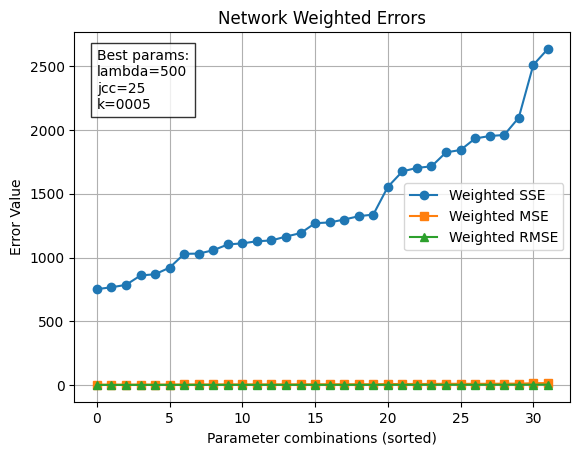

In [25]:
# Plot zigzag lines using marker with line plot, alternating markers for zigzag appearance
x = np.arange(len(net_weighted_errors))
sse = net_weighted_errors['weighted_SSE']
mse = net_weighted_errors['weighted_MSE']
rmse = net_weighted_errors['weighted_RMSE']
plt.plot(x, sse, marker='o', label='Weighted SSE')
plt.plot(x, mse, marker='s', label='Weighted MSE')
plt.plot(x, rmse, marker='^', label='Weighted RMSE')

# Annotate best params on the graph (first row after sorting)
best = net_weighted_errors.iloc[0]
label_text = (f"Best params:\n"
              f"lambda={best['lambda']}\n"
              f"jcc={best['jcc']}\n"
              f"k={best['k']}")
plt.text(x=0, y=max(sse.max(), mse.max(), rmse.max()), s=label_text,
         verticalalignment='top', horizontalalignment='left',
         bbox=dict(facecolor='white', alpha=0.8))

plt.title('Network Weighted Errors')
plt.xlabel('Parameter combinations (sorted)')
plt.ylabel('Error Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Process spheroid data - finding residuals and weighted SSE
all_spheroid = all_spheroid.merge(spheroid_exp_data, how='left', left_on='hour', right_on='Hours')

# Drop duplicate columns and keep only what we need
all_spheroid = all_spheroid.drop(columns=['Hours']) 
all_spheroid["residual"] = all_spheroid["dist_to_cell1"] - all_spheroid["Invasion Distance (um)"]
all_spheroid["weights"] = 1 / (all_spheroid["Error (um)"] ** 2)
all_spheroid['weighted_SSE'] = (all_spheroid['residual'] ** 2) * all_spheroid['weights']

print(all_spheroid.head())

  phenotype  lambda  jcc     k  replicate  hour   mcs  cell_id           x  \
0  spheroid     500    1  0001          1    12   500        1  100.776923   
1  spheroid     500    1  0001          1    24  1000        1  101.220779   
2  spheroid     500    1  0001          1    24  1000        2  103.040000   
3  spheroid     500    1  0001          1    36  1500        1  105.816092   
4  spheroid     500    1  0001          1    36  1500        2  100.166667   

           y  dist_to_cell1  Invasion Distance (um)  Error (um)  residual  \
0  99.138462       2.264240                    5.24        0.77 -2.975760   
1  93.480519      13.273646                    8.56        1.92  4.713646   
2  99.346667       6.106934                    8.56        1.92 -2.453066   
3  95.965517      14.074822                   11.50        1.79  2.574822   
4  98.522222       2.993384                   11.50        1.79 -8.506616   

    weights  weighted_SSE  
0  1.686625     14.935317  
1  0.271267 

In [27]:
# Calculate weighted SSE for each parameter combination
sph_weighted_errors = all_spheroid.groupby(['lambda', 'jcc', 'k']).agg({'weighted_SSE':["sum", 'count']}).reset_index()
sph_weighted_errors.columns = ['lambda', 'jcc', 'k', 'weighted_SSE', 'count']
sph_weighted_errors["weighted_MSE"] = sph_weighted_errors["weighted_SSE"] / sph_weighted_errors["count"]
sph_weighted_errors["weighted_RMSE"] = np.sqrt(sph_weighted_errors["weighted_MSE"])

# Sort by weighted RMSE
sph_weighted_errors = sph_weighted_errors.sort_values('weighted_SSE')

print(sph_weighted_errors.head(10))

# Save to CSV
sph_weighted_errors.to_csv(os.path.join(folder_name2,'all_error_metrics_by_params.csv'), index=False)

# Print best parameters
best = sph_weighted_errors.iloc[0]
print(f"\nBest parameters:")
print(f"  lambda: {best['lambda']}")
print(f"  jcc: {best['jcc']}")
print(f"  k: {best['k']}")
print(f"  Weighted SSE: {best['weighted_SSE']:.4f}")
print(f" Weighted MSE: {best['weighted_MSE']:.4f}")
print(f"  Weighted RMSE: {best['weighted_RMSE']:.4f}")

    lambda  jcc     k  weighted_SSE  count  weighted_MSE  weighted_RMSE
24    1000   15  0001   1201.567544    180      6.675375       2.583675
4      500   10  0001   1473.660426    180      8.187002       2.861294
9      500   15  0005   1536.857728    180      8.538098       2.922002
0      500    1  0001   1566.807521    180      8.704486       2.950337
5      500   10  0005   1584.285224    180      8.801585       2.966746
25    1000   15  0005   1608.025457    180      8.933475       2.988892
21    1000   10  0005   1622.603982    180      9.014467       3.002410
17    1000    1  0005   1784.537320    180      9.914096       3.148666
20    1000   10  0001   1790.047207    180      9.944707       3.153523
1      500    1  0005   1849.742048    180     10.276345       3.205674

Best parameters:
  lambda: 1000
  jcc: 15
  k: 0001
  Weighted SSE: 1201.5675
 Weighted MSE: 6.6754
  Weighted RMSE: 2.5837


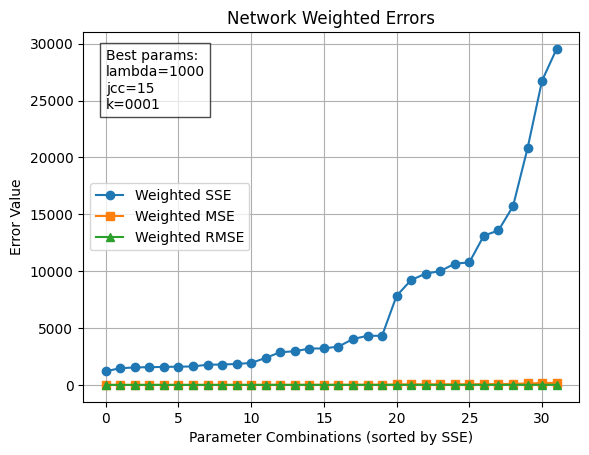

In [29]:
x = np.arange(len(sph_weighted_errors))  

plt.plot(x, sph_weighted_errors['weighted_SSE'], marker='o', label='Weighted SSE')
plt.plot(x, sph_weighted_errors['weighted_MSE'], marker='s', label='Weighted MSE')
plt.plot(x, sph_weighted_errors['weighted_RMSE'], marker='^', label='Weighted RMSE')

# Annotate best params on plot (first row after sort)
best = sph_weighted_errors.iloc[0]
label_text = (f"Best params:\n"
              f"lambda={best['lambda']}\n"
              f"jcc={best['jcc']}\n"
              f"k={best['k']}")
plt.text(0, max(sph_weighted_errors['weighted_SSE'].max(),
               sph_weighted_errors['weighted_MSE'].max(),
               sph_weighted_errors['weighted_RMSE'].max()),
         label_text, verticalalignment='top', horizontalalignment='left',
         bbox=dict(facecolor='white', alpha=0.7))

plt.title('Network Weighted Errors')
plt.xlabel('Parameter Combinations (sorted by SSE)')
plt.ylabel('Error Value')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
network_path = "Processed_Data/network"
all_network.to_csv(os.path.join(network_path, "all_network_data.csv"), index=False)
network_exp_data.to_csv(os.path.join(network_path,"experimental_data_network.csv"), index=False)


spheroid_path = "Processed_Data/spheroids"
all_spheroid.to_csv(os.path.join(spheroid_path, "all_spheroid_data.csv"), index=False)
spheroid_exp_data.to_csv(os.path.join(spheroid_path,"experimental_data_spheroid.csv"), index=False)